# Convert HOBO sensor Excel files to parquet

In [1]:
import os
import datetime
from pprint import pprint

import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from bokeh.io import output_notebook, show

output_notebook()


Loading BokehJS ...

In [2]:
srcdir = 'data/src/hobo'
dstdir = 'data/dst'

In [3]:
ext = '.xlsx'

hobo_files = [file for file in os.listdir(srcdir) if file.endswith(ext)]
print(f'Found {len(hobo_files)} files:')
pprint(hobo_files)

Found 19 files:
['21852517 2024-07-22 10_25_20 EDT (Data EDT).xlsx',
 '21963948 2024-09-26 09_05_40 EDT (Data EDT).xlsx',
 '21963949 2024-09-26 09_12_21 EDT (Data EDT).xlsx',
 '21963950 2024-09-26 09_26_11 EDT (Data EDT).xlsx',
 '21963951 2024-09-26 09_05_01 EDT (Data EDT).xlsx',
 'FM-Temp-21695005 2024-09-14 13_49_22 EDT (Data EDT).xlsx',
 'FM-Temp-21695007-CB 2024-07-22 10_20_59 EDT (Data EDT).xlsx',
 'FM-Temp-21695007-CB 2024-09-14 10_54_37 EDT (Data EDT).xlsx',
 'FM-Temp-21695008-CB 2024-09-14 12_38_17 EDT (Data EDT).xlsx',
 'FM-Temp-21852518-LB 2024-07-22 10_18_03 EDT (Data EDT).xlsx',
 'FM-Temp-21852518-LB 2024-09-14 11_19_31 EDT (Data EDT).xlsx',
 'FM-Temp-21852519 2024-07-22 10_21_36 EDT (Data EDT).xlsx',
 'FM-Temp-21852519 2024-09-14 11_28_52 EDT (Data EDT).xlsx',
 'FM-Temp-21852520 2024-09-14 15_06_56 EDT (Data EDT).xlsx',
 'FM-Temp-21852521-FD 2024-07-22 10_22_54 EDT (Data EDT).xlsx',
 'FM-Temp-21852521-FD 2024-09-14 11_53_27 EDT (Data EDT).xlsx',
 'FM-Temp-21852524-CT 2024-

In [4]:
def read_hobo(fn, srcdir='.', to_freq='15min'):
    
    df = pd.read_excel(f'{srcdir}/{fn}', parse_dates=True, date_format='%Y-%m-%d %H:%M:%S', names=['DateTimeEDT','Temp'])

    # Localize to EDT as indicated in header
    df['DateTimeEDT'] = df['DateTimeEDT'].dt.tz_localize('America/New_York')

    df.set_index(df['DateTimeEDT'], inplace=True)
    df.index.rename('DateTime', inplace=True)

    in_freq = pd.infer_freq(df.index)
    df = df.resample('1min').first().interpolate().resample(to_freq).asfreq()

    # update the index to UTC
    df.index = df.index.tz_convert(pytz.utc)

    return df

In [5]:
for file in hobo_files:
    df = read_hobo(file, srcdir=srcdir, to_freq='10min')
    basename = os.path.splitext(file)[0].replace('EDT', 'UTC')
    print(f'Writing: {basename}')

    df.to_parquet(f'{dstdir}/{basename}.parquet', index=True)

Writing: 21852517 2024-07-22 10_25_20 UTC (Data UTC)
Writing: 21963948 2024-09-26 09_05_40 UTC (Data UTC)
Writing: 21963949 2024-09-26 09_12_21 UTC (Data UTC)
Writing: 21963950 2024-09-26 09_26_11 UTC (Data UTC)
Writing: 21963951 2024-09-26 09_05_01 UTC (Data UTC)
Writing: FM-Temp-21695005 2024-09-14 13_49_22 UTC (Data UTC)
Writing: FM-Temp-21695007-CB 2024-07-22 10_20_59 UTC (Data UTC)
Writing: FM-Temp-21695007-CB 2024-09-14 10_54_37 UTC (Data UTC)
Writing: FM-Temp-21695008-CB 2024-09-14 12_38_17 UTC (Data UTC)
Writing: FM-Temp-21852518-LB 2024-07-22 10_18_03 UTC (Data UTC)
Writing: FM-Temp-21852518-LB 2024-09-14 11_19_31 UTC (Data UTC)
Writing: FM-Temp-21852519 2024-07-22 10_21_36 UTC (Data UTC)
Writing: FM-Temp-21852519 2024-09-14 11_28_52 UTC (Data UTC)
Writing: FM-Temp-21852520 2024-09-14 15_06_56 UTC (Data UTC)
Writing: FM-Temp-21852521-FD 2024-07-22 10_22_54 UTC (Data UTC)
Writing: FM-Temp-21852521-FD 2024-09-14 11_53_27 UTC (Data UTC)
Writing: FM-Temp-21852524-CT 2024-07-22 10_

2024-07-29 19:10:00+00:00 2024-09-14 18:30:00+00:00


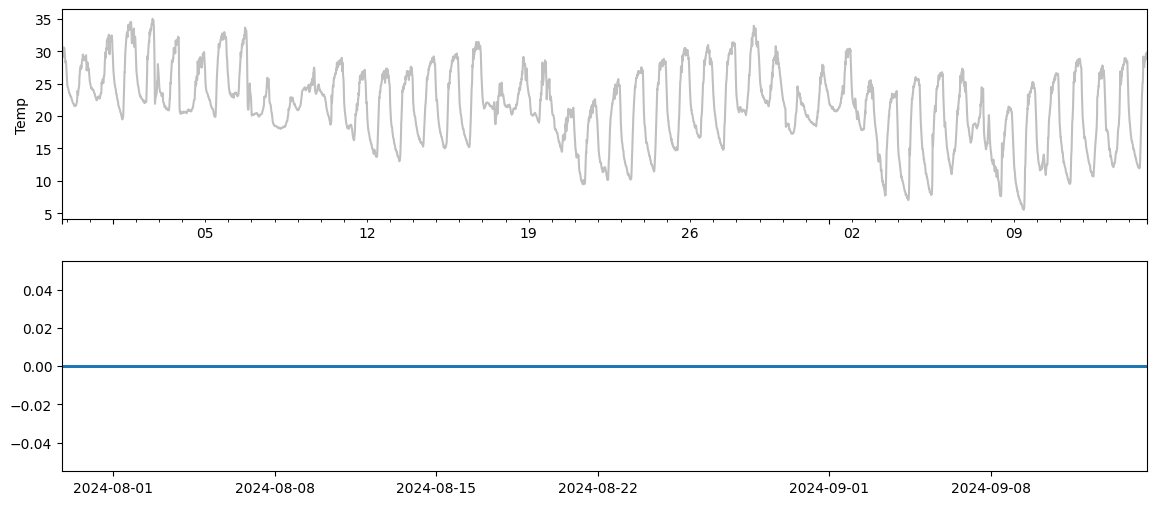

In [6]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(14,6)

start = df.first_valid_index()
stop = df.last_valid_index()
print(start, stop)

df[start:stop][col].plot(ax=ax[0], color='gray', alpha=0.5)

# add some nodata marks
dfmask = pd.isnull(df[start:stop][col])

ax[1].plot(dfmask.index, dfmask.mask(dfmask == False),
         color='tab:red', marker='.', markersize=1.2,
         label='nodata')

ax[1].plot(dfmask.index, dfmask.mask(dfmask == True),
         color='tab:blue', marker='.', markersize=1.2,
         label='data')

ax[1].set_xlim(start, stop)
    
ax[0].set_ylabel(f'{col}')
plt.show()